In [1]:
import pathlib
import numpy as np

from fytok.Tokamak import Tokamak
from spdm.view import View as sp_view

data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

2023-12-22 11:37:35,802 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-12-22T11:37:35.542776.
 Job ID: fytok_salmon_surface_890

###################################################################################################



In [2]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    equilibrium={"code": {"parameters": {"psi_norm": np.linspace(0.01, 0.996, 64)}}},
    core_transport={
        "model": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "collisional_equipartition"}},
            {"code": {"name": "fusion_reaction", "parameters": {"reactions": ["D(t,n)alpha"]}}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.999, 128),
                "bvp_rms_mask": [0.96],
                "hyper_diff": 0.0001,
                # "max_nodes": 256,
                "bc_tol": 1e8,
                "verbose": 2,
            },
        },
        "thermal_particle": ["D", "T"],  #
        "fast_particle": ["alpha", "He"],
        "impurities": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            "*|density"         : (2, 1),
            "*|temperature"             : (2, 1),
            "electrons|temperature"     : (2, 1),
            # fmt: on
        },
        "normalize_units": {
            "*|density": 1.0e21,
            "*|density_flux": 1.0e24,
            "ion|alpha|density": 1.0e18,
            "ion|alpha|density_flux": 1.0e21,
            "ion|He|density": 1.0e18,
            "ion|He|density_flux": 1.0e20,
            "*|temperature": 1.0e6,
            "*|temperature_flux": 1.0e27,
        },
    },
)

2023-12-22 11:37:35,969 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml
2023-12-22 11:37:36,136 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2023-12-22 11:37:36,191 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk


In [3]:
tokamak.transport_solver.refresh(
    time=0.0,
    # fmt:off
    initial_value={
        "ion/D/density":                    1.0e19,
        "ion/T/density":                    1.0e19,
        "ion/He/density":                   0.0,
        "ion/alpha/density":                0.0,

        "ion/D/temperature":                200,
        "ion/T/temperature":                200,
        "ion/He/temperature":               200,
        "electrons/temperature":            200,
    },
    boundary_value={
        "ion/D/density":                    ([0.0], [1.3e19]), 
        "ion/T/density":                    ([0.0], [1.3e19]), 
        "ion/He/density":                   ([0.0], [1.0]), 
        "ion/alpha/density":                ([0.0], [1.0]), 

        "ion/D/temperature":                ([0.0], [200]),   
        "ion/T/temperature":                ([0.0], [200]),   
        "ion/He/temperature":               ([0.0], [200]),   

        "electrons/temperature":            ([0.0], [200]),   
    },
    # fmt:on
)
solver_1d = tokamak.transport_solver.time_slice.current

2023-12-22 11:37:36,230 [    spdm]     INFO: Load module fytok.plugins.transport_solver_numerics.fy_trans
2023-12-22 11:37:36,505 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2023-12-22 11:37:36,508 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2023-12-22 11:37:36,512 [    spdm]     INFO: Initialize module fytok.modules.TF 
2023-12-22 11:37:36,515 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2023-12-22 11:37:36,520 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2023-12-22 11:37:36,523 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.fy_eq 
2023-12-22 11:37:36,535 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2023-12-22 11:37:36,543 [    spdm]     INFO: Initialize module fytok.modules.CoreTransport 
2023-12-22 11:37:36,549 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2023-12-22 11:37:36,554 [    spdm]     INFO: Initialize module fytok.plugins.transport_solver_num

2023-12-22 11:37:42,357 [    spdm]     INFO: Load module spdm.view.view_matplotlib


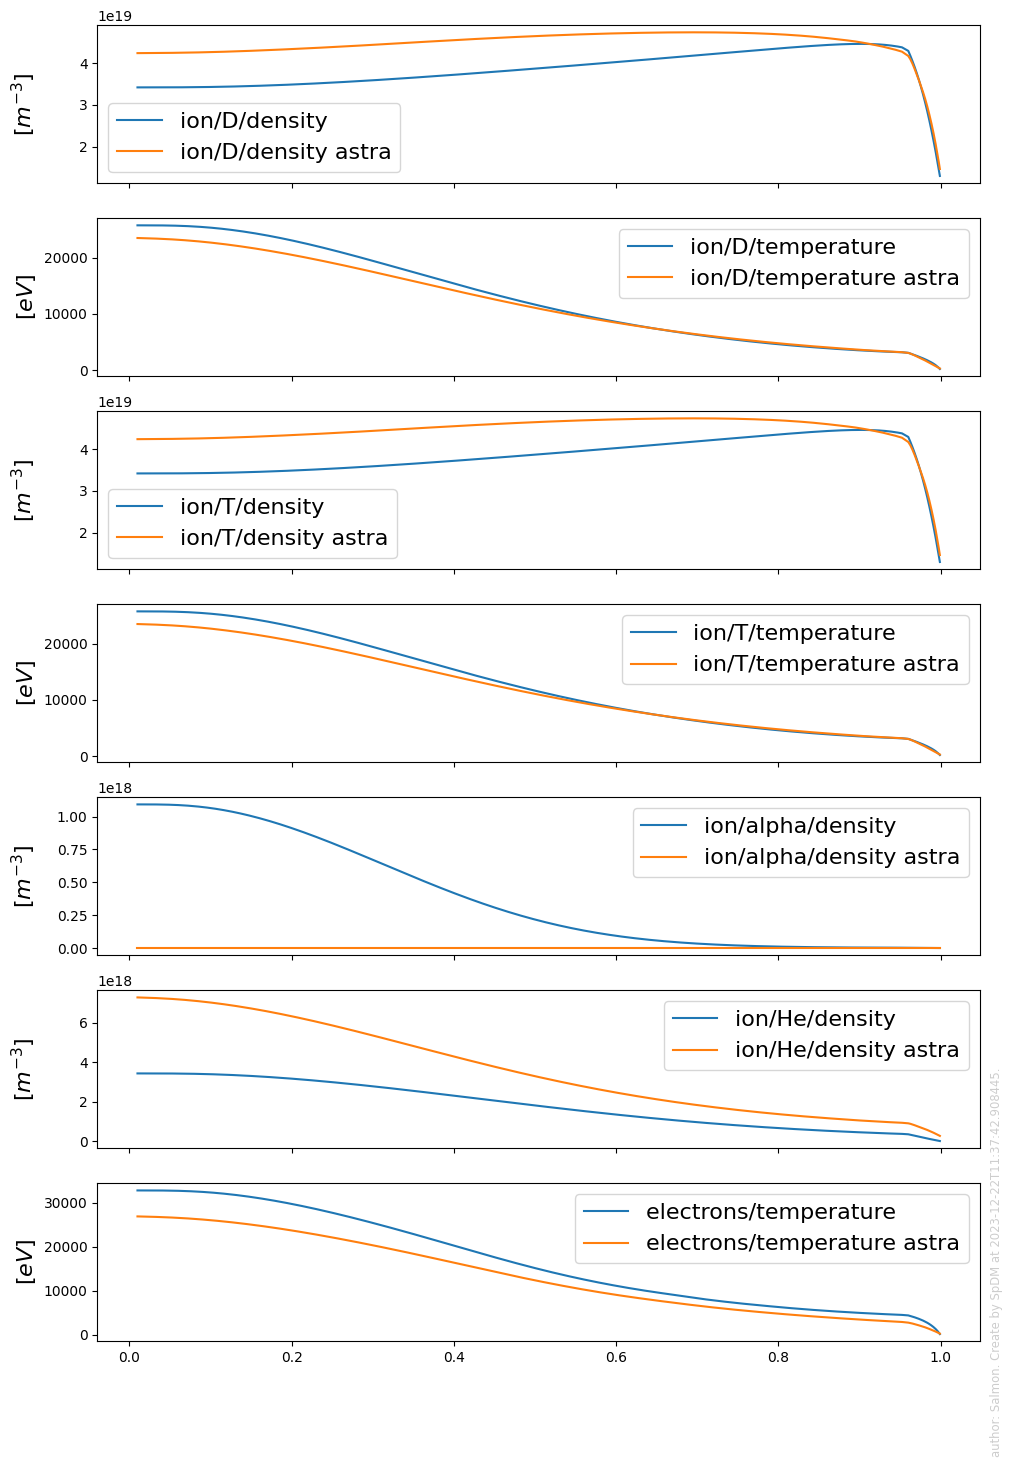

In [4]:
core_profiles_1d = tokamak.transport_solver.fetch()
core_profiles_1d_astra = tokamak.core_profiles.time_slice.current.profiles_1d
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *[
        [
            (core_profiles_1d.get(equ.identifier,0), rf"{equ.identifier} "),
            (core_profiles_1d_astra.get(equ.identifier, 0), rf"{equ.identifier} astra"),
        #    ( solver_1d.Y0[idx],equ.identifier)
        ]
        for idx, equ in enumerate(solver_1d.equations)
    ],
)

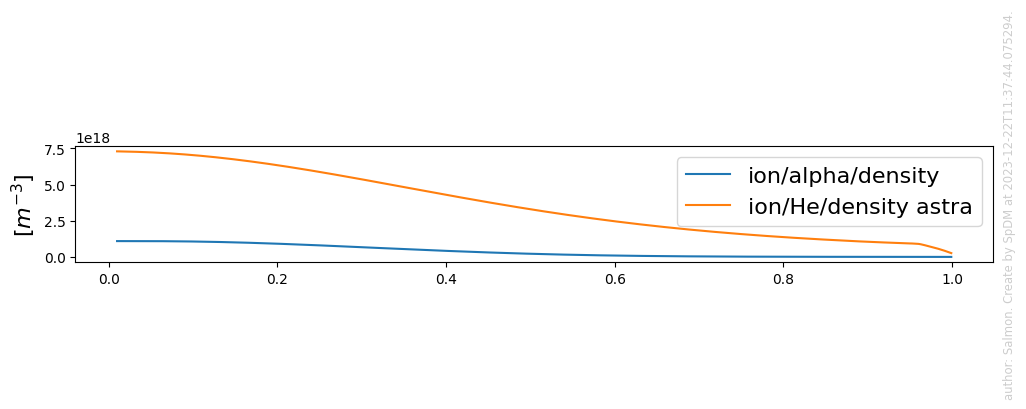

In [5]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        # (core_profiles_1d.get("ion/D/density"), "ion/D/density"),
        # (core_profiles_1d.get("electrons/density"), "electrons/density"),
        (core_profiles_1d.get("ion/alpha/density"), "ion/alpha/density"),
        (core_profiles_1d_astra.get("ion/He/density"), "ion/He/density astra"),
        #    ( solver_1d.Y0[idx],equ.identifier)
    ],
)

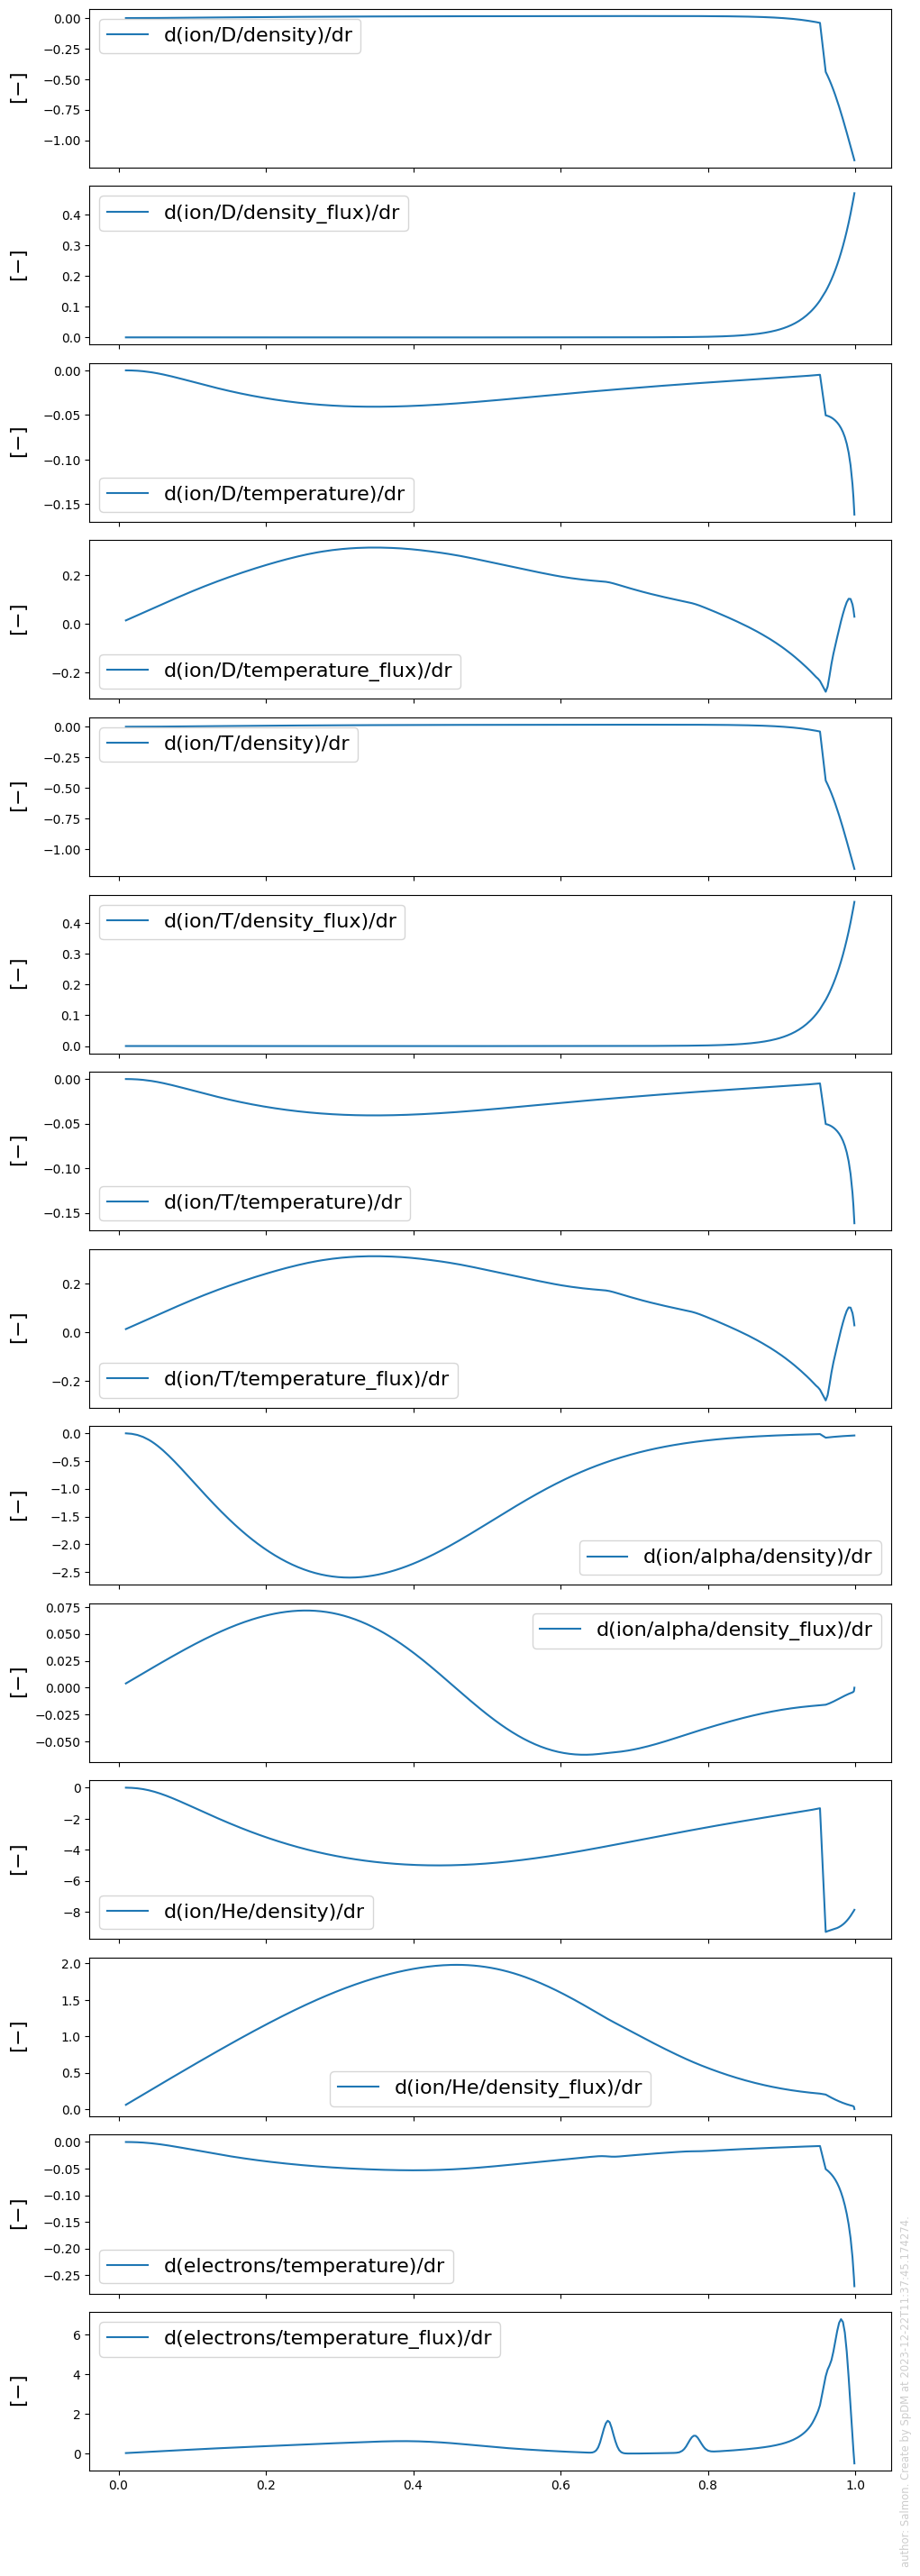

In [6]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (solver_1d.Y0[2 * idx], f"d({equ.identifier})/dr"),
                # (solver_1d.Y0[2 * idx + 1], f"d({equ.identifier}_flux)/dr"),
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for idx, equ in enumerate(solver_1d.equations)
        ],
        [],
    ),
)

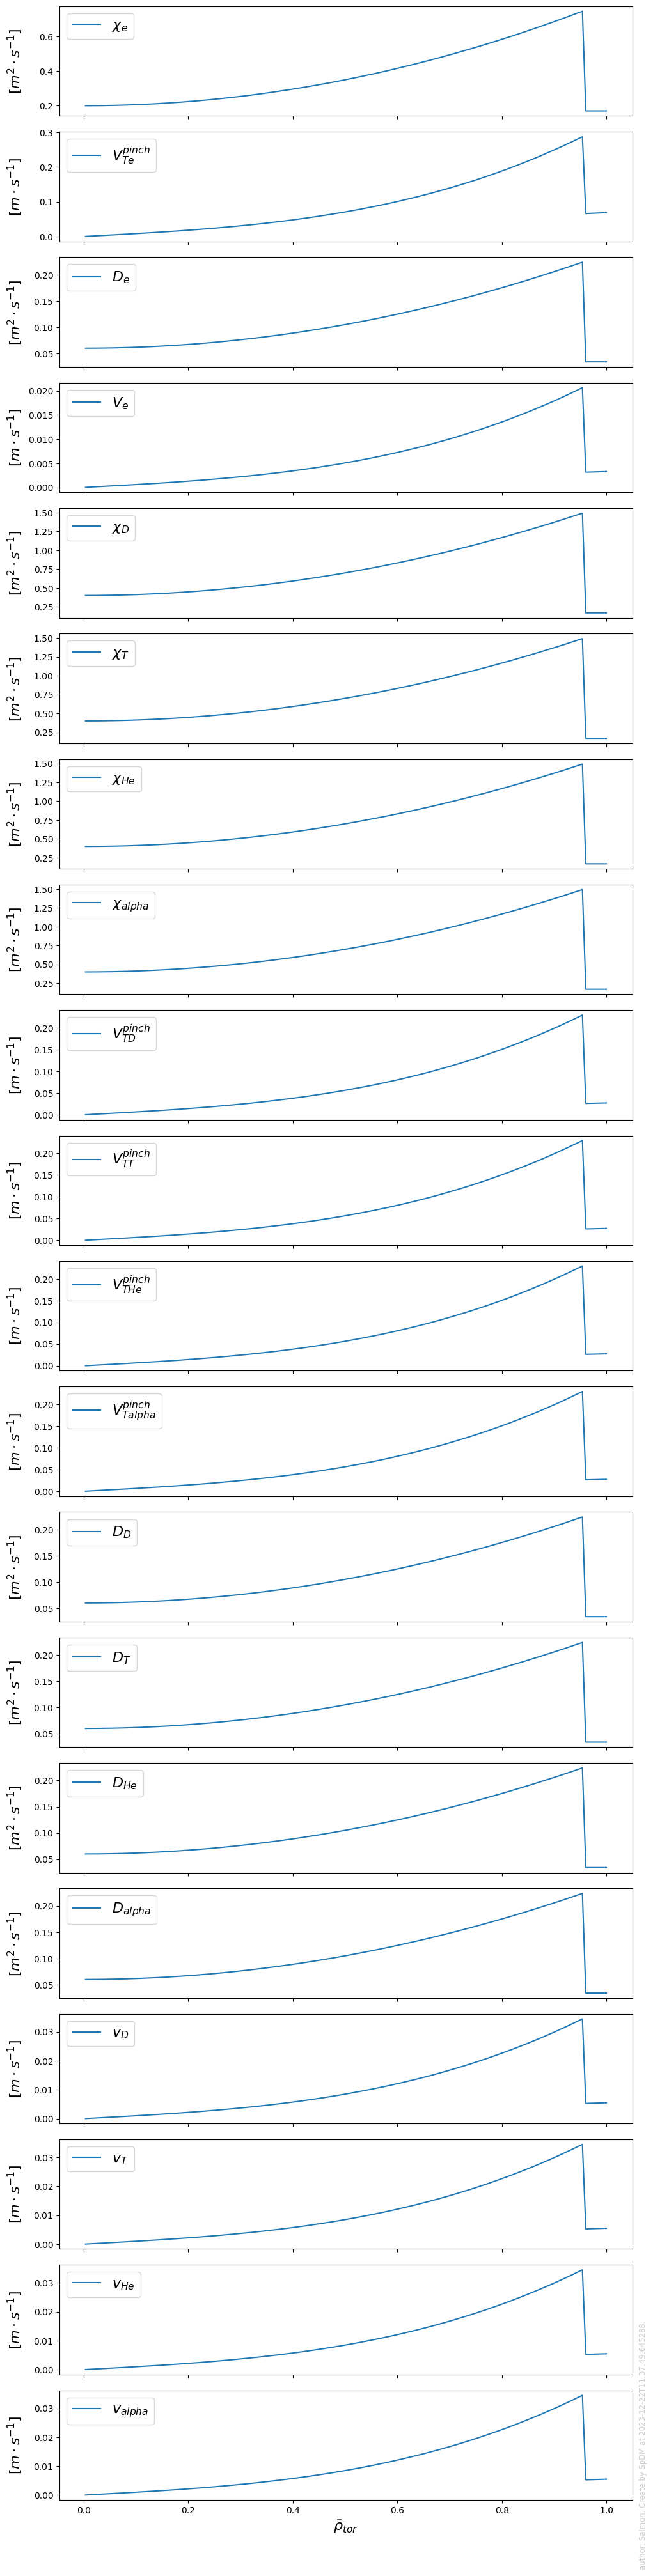

In [7]:
core_transport_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    core_transport_1d.grid_d.rho_tor_norm,
    (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
    (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
    # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
    # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
    (core_transport_1d.electrons.particles.d, r"$D_e$"),
    (core_transport_1d.electrons.particles.v, r"$V_e$"),
    *[(ion.energy.d, rf"$\chi_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    *[(ion.energy.v, rf"$V^{{pinch}}_{{T{ion.label}}}$") for ion in core_transport_1d.ion],
    *[(ion.particles.d, rf"$D_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    *[(ion.particles.v, rf"$v_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    x_label=r"$\bar{\rho}_{tor}$",
)

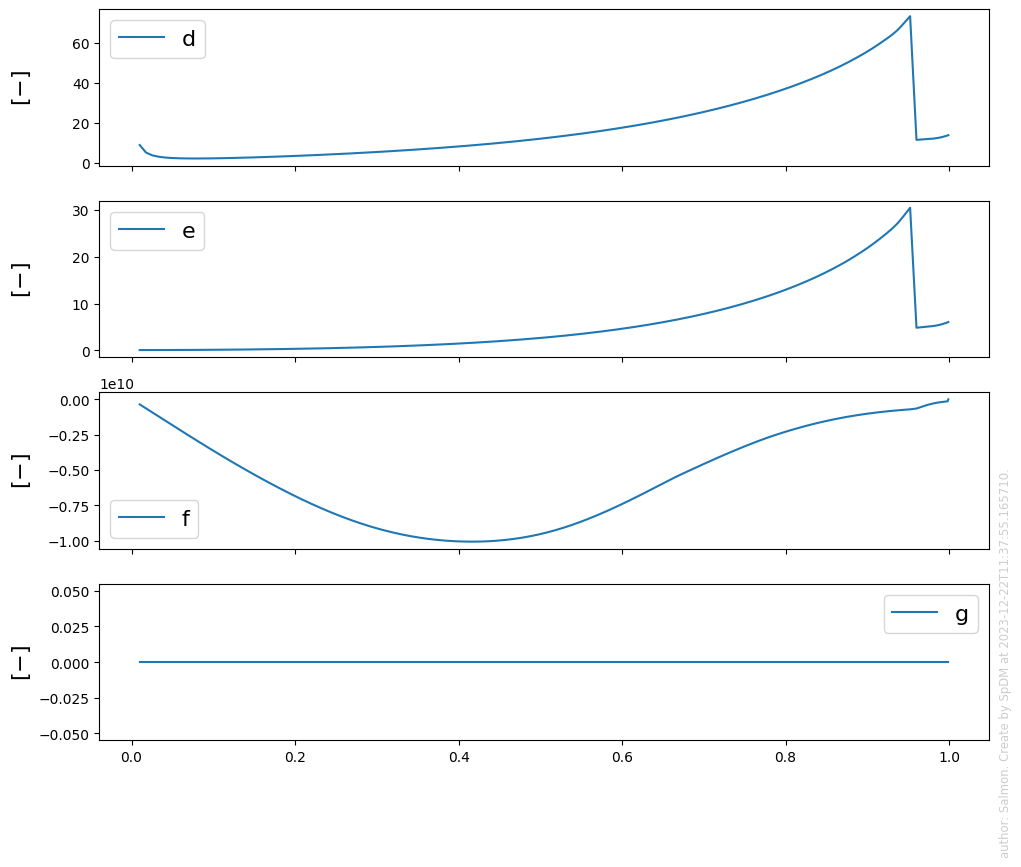

In [8]:
variables = sum([[equ.profile, equ.flux] for equ in solver_1d.equations], [])
equ = solver_1d.equations[4]
bc0,bc1, a, b, c, d, e, f, g,ym = equ.coefficient
x = solver_1d.grid.rho_tor_norm
# y = equ.profile
# yp = equ.d_dr
# flux = equ.flux
# dflux = equ.dflux_dr
fig = sp_view.plot(
    x,
    # (a(x, *variables), "a"),
    # (b(x, *variables), "b"),
    # (c(x,*vars), "c"),
    (d(x, *variables), "d"),
    (e(x, *variables), "e"),
    (f(x, *variables), "f"),
    (g(x, *variables), "g"),
    # tokamak.transport_solver.equations[2].d_dr,
    # [
    #     (d*yp, "$D$"),
    #     (e*y,   "$v$"),
    #     # (flux,   f"$\Gamma$"),
    #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
    #     # ((-d*yp+e*y).I, r"$\Gamma$"),
    #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),
    # ],
    # y, yp
    # [
    #     (dflux, {"label": r"$d\Gamma$"}),
    #     # (Function(flux, x).d(), r"$d\Gamma$"),
    #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
    # ],
)

In [9]:
solver_1d.equations[4].identifier

'ion/alpha/density'

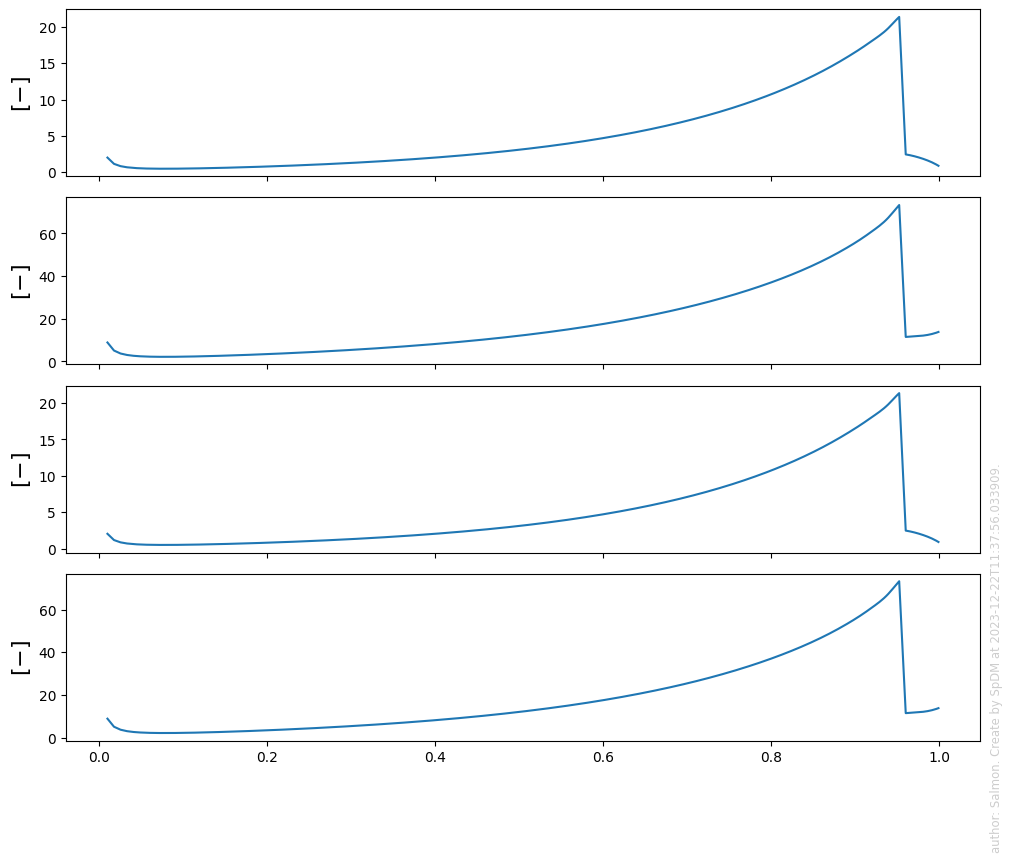

In [10]:
fig = sp_view.plot(
    x,
    solver_1d.equations[1].coefficient[5](x, *variables),
    solver_1d.equations[2].coefficient[5](x, *variables),
    solver_1d.equations[3].coefficient[5](x, *variables),
    solver_1d.equations[4].coefficient[5](x, *variables),
)